# Probabilistic Methods (Discrete)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

**Anomaly Detection:** Identification of items, events or observations which is significantly different from the remaining data.

- Non-parametric approach
- Frequency or counting based
    - How many time a value of variable (e.g. ip address) shows up
    - More frequent - less likely to be an anomaly
    - less frequent - more likely to be an anomaly
    - Calculate probability 

    
- Conditional probability 
    $$ {P(A|B) = }\frac{\text{P(A U B)}}{\text{P(B)}} $$
    
    
 Examples: 
- How many times we see an ip address in the dataset (count)
- What is probability of ip address showing up in the dataset (ip count / total observations)
- Conditional probability. Given an ip address, what is prob of a particular status(e.g authentication failure)

### Wrangle

The data comes from the webserver logs of the API that we used in the timeseries module. Each row is one request to the server

In [3]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)

In [4]:
df.head(2)

,entry
0,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
1,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...


In [5]:
df['entry'][0]

'97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] "GET /api/v1/sales?page=81 HTTP/1.1" 200 512495 "-" "python-requests/2.21.0"'

In [6]:
df['entry'][1]

'97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] "GET /api/v1/items HTTP/1.1" 200 3561 "-" "python-requests/2.21.0"'

In [7]:
df['entry'][0].split()

['97.105.19.58',
 '-',
 '-',
 '[16/Apr/2019:19:34:42',
 '+0000]',
 '"GET',
 '/api/v1/sales?page=81',
 'HTTP/1.1"',
 '200',
 '512495',
 '"-"',
 '"python-requests/2.21.0"']

In [8]:
parts = df['entry'][0].split()
output = {}

output['ip'] = parts[0]
output['timestamp'] = parts[3][1:].replace(':', ' ', 1)


In [9]:
pd.Series(output)

ip                   97.105.19.58
timestamp    16/Apr/2019 19:34:42
dtype: object

In [10]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

In [11]:
df = df.entry.apply(parse_log_entry)

In [12]:
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [13]:
# Synthetic data
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)

/var/folders/95/4_dk01yj6rlfg_gvkbsmzqhm0000gp/T/ipykernel_34567/2524790224.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new)


In [14]:
df.tail(3)

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
1,95.31.16.121,17/Apr/2019 19:36:41,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0
2,97.105.15.120,18/Apr/2019 19:42:41,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0
3,97.105.19.58,19/Apr/2019 19:42:41,GET,/api/v1/sales?page=79/,HTTP/1.1,200,2056327,python-requests/2.21.0


In [15]:
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [16]:
df.head(2)

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396


## Detecting Anomalies in Discrete Variables

- **count**: the number of times each unique value appears in the dataset
- **frequencies**: the number of times each unique value appears in the dataset as a percentage of the total; the count divided by the total number of observations

In [17]:
df.ip.value_counts()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
35.175.171.137        2
52.87.230.102         2
70.121.214.34         2
52.90.165.200         1
95.31.16.121          1
95.31.18.119          1
45.23.250.16          1
52.91.30.150          1
34.207.64.242         1
3.88.129.158          1
54.172.14.223         1
3.92.201.136          1
35.174.209.2          1
54.145.52.184         1
34.229.70.250         1
97.105.15.120         1
Name: ip, dtype: int64

In [18]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'count'})
ip_df.head()

,ip,count
0,97.105.19.58,11999
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,68.201.219.223,21


In [19]:
# calculate probabity for each ip 

# ip_prob = count for each ip / total count in the dataframe

ip_df2 = pd.DataFrame((df.ip.value_counts(dropna=False))/df.ip.count()).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'proba'})
ip_df2.head()

,ip,proba
0,97.105.19.58,0.858420
1,173.173.113.51,0.075762
2,72.181.113.170,0.043855
3,72.181.105.81,0.017599
4,68.201.219.223,0.001502


In [20]:
# merge the two data frames create above into a single one:
ip_df = ip_df.merge(ip_df2, on='ip')
ip_df.head()

,ip,count,proba
0,97.105.19.58,11999,0.858420
1,173.173.113.51,1059,0.075762
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,68.201.219.223,21,0.001502


From here we can find how many unique ip addresses there are:

In [21]:
ip_df.set_index('ip')['count'].sort_values()

ip
95.31.16.121          1
54.145.52.184         1
35.174.209.2          1
3.92.201.136          1
54.172.14.223         1
3.88.129.158          1
34.207.64.242         1
52.91.30.150          1
45.23.250.16          1
95.31.18.119          1
97.105.15.120         1
52.90.165.200         1
34.229.70.250         1
70.121.214.34         2
52.87.230.102         2
35.175.171.137        2
24.26.242.9          21
68.201.219.223       21
72.181.105.81       246
72.181.113.170      613
173.173.113.51     1059
97.105.19.58      11999
Name: count, dtype: int64

<AxesSubplot:ylabel='ip'>

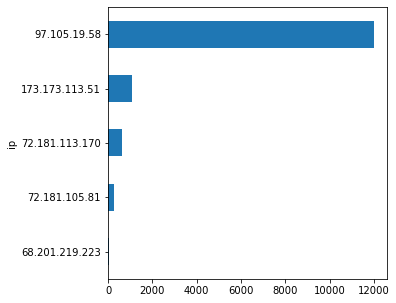

In [22]:
ip_df.set_index('ip')['count'].sort_values().tail(5).plot.barh(figsize=(5,5))

<AxesSubplot:ylabel='ip'>

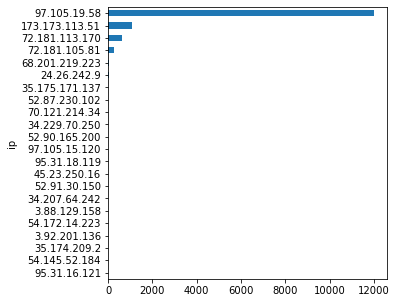

In [23]:
ip_df.set_index('ip')['count'].sort_values().plot.barh(figsize=(5,5))

### Conditional Probabilities

- What is probability of a certain status code given an IP address?

HTTP Status Codes

- 200: ok
- 3xx: redirects
- 4xx: client level errors -- the requester did something wrong
- 5xx: server level errors -- the server did something wrong

In [24]:
# prob(A|B) = prob(A & B)/prob(B)

In [25]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [26]:
Pab = df.groupby(['ip', 'status_code']).size()/len(df)

In [27]:
Pab

ip              status_code
173.173.113.51  200            0.075762
24.26.242.9     200            0.001502
3.88.129.158    200            0.000072
3.92.201.136    200            0.000072
34.207.64.242   200            0.000072
34.229.70.250   200            0.000072
35.174.209.2    200            0.000072
35.175.171.137  200            0.000143
45.23.250.16    200            0.000072
52.87.230.102   200            0.000143
52.90.165.200   200            0.000072
52.91.30.150    200            0.000072
54.145.52.184   200            0.000072
54.172.14.223   200            0.000072
68.201.219.223  200            0.001502
70.121.214.34   200            0.000143
72.181.105.81   200            0.017599
72.181.113.170  200            0.043712
                499            0.000143
95.31.16.121    301            0.000072
95.31.18.119    200            0.000072
97.105.15.120   301            0.000072
97.105.19.58    200            0.857419
                499            0.001002
dtype: float

In [28]:
Pb = df.groupby('ip').size()/len(df)

In [29]:
Pb

ip
173.173.113.51    0.075762
24.26.242.9       0.001502
3.88.129.158      0.000072
3.92.201.136      0.000072
34.207.64.242     0.000072
34.229.70.250     0.000072
35.174.209.2      0.000072
35.175.171.137    0.000143
45.23.250.16      0.000072
52.87.230.102     0.000143
52.90.165.200     0.000072
52.91.30.150      0.000072
54.145.52.184     0.000072
54.172.14.223     0.000072
68.201.219.223    0.001502
70.121.214.34     0.000143
72.181.105.81     0.017599
72.181.113.170    0.043855
95.31.16.121      0.000072
95.31.18.119      0.000072
97.105.15.120     0.000072
97.105.19.58      0.858420
dtype: float64

In [30]:
Pab / Pb

ip              status_code
173.173.113.51  200            1.000000
24.26.242.9     200            1.000000
3.88.129.158    200            1.000000
3.92.201.136    200            1.000000
34.207.64.242   200            1.000000
34.229.70.250   200            1.000000
35.174.209.2    200            1.000000
35.175.171.137  200            1.000000
45.23.250.16    200            1.000000
52.87.230.102   200            1.000000
52.90.165.200   200            1.000000
52.91.30.150    200            1.000000
54.145.52.184   200            1.000000
54.172.14.223   200            1.000000
68.201.219.223  200            1.000000
70.121.214.34   200            1.000000
72.181.105.81   200            1.000000
72.181.113.170  200            0.996737
                499            0.003263
95.31.16.121    301            1.000000
95.31.18.119    200            1.000000
97.105.15.120   301            1.000000
97.105.19.58    200            0.998833
                499            0.001167
dtype: float

In [31]:
# Given a particular ip, what is probability of a certain status code
status_given_ip = (
    df.groupby('ip')\
    .status_code.value_counts(normalize=True)\
    .rename('proba_status_given_ip')\
    .reset_index())
status_given_ip

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [32]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]

,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


In [33]:
df[df.ip == '72.181.113.170'].sort_values(by='status_code', ascending=False)

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-17 02:48:36,72.181.113.170,GET,/api/v1/sales?page=8,HTTP/1.1,499,0,python-requests/2.21.0,0.000000
2019-04-17 03:42:44,72.181.113.170,GET,/api/v1/sales?page=133,HTTP/1.1,499,0,python-requests/2.21.0,0.000000
2019-04-17 03:42:17,72.181.113.170,GET,/api/v1/sales?page=120,HTTP/1.1,200,510681,python-requests/2.21.0,0.487023
2019-04-17 03:42:01,72.181.113.170,GET,/api/v1/sales?page=113,HTTP/1.1,200,511094,python-requests/2.21.0,0.487417
2019-04-17 03:42:03,72.181.113.170,GET,/api/v1/sales?page=114,HTTP/1.1,200,511291,python-requests/2.21.0,0.487605
...,...,...,...,...,...,...,...,...
2019-04-17 03:28:07,72.181.113.170,GET,/api/v1/sales?page=100,HTTP/1.1,200,512674,python-requests/2.21.0,0.488924
2019-04-17 03:28:08,72.181.113.170,GET,/api/v1/sales?page=101,HTTP/1.1,200,510509,python-requests/2.21.0,0.486859
2019-04-17 03:28:11,72.181.113.170,GET,/api/v1/sales?page=102,HTTP/1.1,200,512612,python-requests/2.21.0,0.488865


* Cases where the probability is < 100%
* Status codes other than 200

In [34]:
status_given_ip[status_given_ip.status_code != '200']

,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
19,95.31.16.121,301,1.000000
21,97.105.15.120,301,1.000000
23,97.105.19.58,499,0.001167


#### How do we use this if we are looking to apply assumptions on unseen data?

In [35]:
df.sort_index().head(1)

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753


In [36]:
df.sort_index().tail(5)

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-17 12:55:14,97.105.19.58,GET,/api/v1/sales?page=71,HTTP/1.1,200,510166,python-requests/2.21.0,0.486532
2019-04-17 19:36:41,95.31.16.121,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0,0.000958
2019-04-18 19:42:41,97.105.15.120,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0,0.002441
2019-04-19 19:42:41,97.105.19.58,GET,/api/v1/sales?page=79/,HTTP/1.1,200,2056327,python-requests/2.21.0,1.961066
2019-04-21 10:02:41,95.31.18.119,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0,1.099591


In [37]:
# create a training set (removing the fake data I added earlier)
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']

In [38]:
len(train), len(df)

(13974, 13978)

#### Join the probabilities of these events to the original dataframe to detect anomalous events:

In [39]:
status_given_ip # Essentially a list of the probability of each ip/status code combination

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [40]:
df = df.reset_index().merge(status_given_ip, on=['ip', 'status_code'], how='left').fillna(value=0).set_index('timestamp')

In [41]:
df[df.proba_status_given_ip < 0.15]

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,proba_status_given_ip
timestamp,,,,,,,,,
2019-04-16 19:55:15,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.20.1,0.0,0.001167
2019-04-16 19:56:02,97.105.19.58,GET,/api/v1/sales?page=21,HTTP/1.1,499,0,python-requests/2.20.1,0.0,0.001167
2019-04-16 20:28:46,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.001167
2019-04-16 20:33:24,97.105.19.58,GET,/api/v1/sales?page=29,HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.001167
2019-04-16 20:38:13,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.001167
2019-04-16 20:38:55,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.001167
2019-04-16 20:39:00,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.001167
2019-04-16 20:45:17,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.001167
2019-04-16 20:45:28,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.001167


**All low probability combinations are now easily identifiable with all additional data intact.**